# Классификация рукописынх цифр MNIST

In [1]:
import os
import struct
import numpy as np

In [11]:
def load_mnist(path, kind='train'):
    labels_path = os.path.join(path,
                               f'{kind}-labels.idx1-ubyte')
    images_path = os.path.join(path,
                               f'{kind}-images.idx3-ubyte')

    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('<II',
                                 lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII',
                                               imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
        images = ((images / 255.) - .5) * 2  # нормализация значений

    return images, labels

In [12]:
X_train, y_train = load_mnist('_mnist', kind='train')
print(X_train.shape)
X_test, y_test = load_mnist('_mnist', kind='t10k')
print(X_test.shape)

(60000, 784)
(10000, 784)


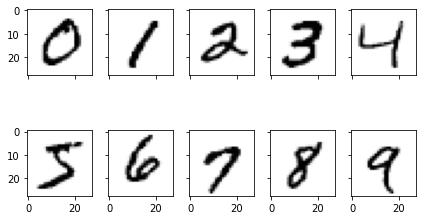

In [34]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

plt.tight_layout()
plt.show()

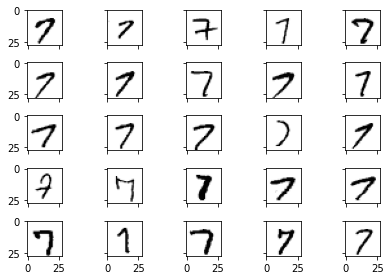

In [37]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = X_train[y_train == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

plt.tight_layout()
plt.show()

Сохранение отмасштабированных признаков в оптимальном формате:

In [39]:
np.savez_compressed('mnist_scaled.npz',
                    X_train=X_train,
                    y_train=y_train,
                    X_test=X_test,
                    y_test=y_test)

In [1]:
import numpy as np

mnist = np.load('mnist_scaled.npz')
mnist.files

['X_train', 'y_train', 'X_test', 'y_test']

In [2]:
X_train, y_train, X_test, y_test = [mnist[i] for i in mnist.files]

In [3]:
import numpy as np
import sys


class NeuralNetMLP(object):
    """ Feedforward neural network / Multi-layer perceptron classifier.

    Parameters
    ------------
    n_hidden : int (default: 30)
        Количество скрытых элементов.
    l2 : float (default: 0.)
        Значение лямбда для регуляризации L2.
        Нет регуляризации при l2=0.
    epochs : int (default: 100)
        Количество проходов по обучающему набору.
    eta : float (default: 0.001)
        Скорость обучения, learning rate.
    shuffle : bool (default: True)
        Если True, тогда обучающие образцы тасуются.
    minibatch_size : int (default: 1)
        Количество обучающих образцов на мини-пакет.
    seed : int (default: None)
        Инициализация весов и тасования.

    Attributes
    -----------
    eval_ : dict
      Словарь, в котором собираются показатели потерь для каждой эпохи во время
      обучения.

    """
    def __init__(self, n_hidden=30,
                 l2=0., epochs=100, eta=0.001,
                 shuffle=True, minibatch_size=1, seed=None):

        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size

    def _onehot(self, y, n_classes):
        """Кодирование меток в представление с унитарным кодом

        Parameters
        ------------
        y : array, shape = [n_examples]
            Целевые значения.
        n_classes : int
            Количество классов.

        Returns
        -----------
        onehot : array, shape = (n_examples, n_labels)

        """
        onehot = np.zeros((y.shape[0], n_classes))
        for idx, val in enumerate(y.astype(int)):
            onehot[idx, val] = 1.
        return onehot

    def _sigmoid(self, z):
        """Вычисляет логистическую (сигмоидальную) функцию"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def _forward(self, X):
        """Вычисляет шаг прямого распространения"""

        # step 1: общий вход скрытого слоя
        # [n_examples, n_features] dot [n_features, n_hidden]
        # -> [n_examples, n_hidden]
        z_h = np.dot(X, self.w_h) + self.b_h

        # step 2: активация скрытого слоя
        a_h = self._sigmoid(z_h)

        # step 3: общий вход выходного слоя
        # [n_examples, n_hidden] dot [n_hidden, n_classlabels]
        # -> [n_examples, n_classlabels]

        z_out = np.dot(a_h, self.w_out) + self.b_out

        # step 4: активация выходного слоя
        a_out = self._sigmoid(z_out)

        return z_h, a_h, z_out, a_out

    def _compute_cost(self, y_enc, output):
        """Вычисляет функцию потерь.

        Parameters
        ----------
        y_enc : array, shape = (n_examples, n_labels)
            one-hot encoded метки классов.
        output : array, shape = [n_examples, n_output_units]
            Активация выходного слоя (прямое распространение)

        Returns
        ---------
        cost : float
            Регуляризированные потери

        """
        L2_term = (self.l2 *
                   (np.sum(self.w_h ** 2.) +
                    np.sum(self.w_out ** 2.)))

        term1 = -y_enc * (np.log(output))
        term2 = (1. - y_enc) * np.log(1. - output)
        cost = np.sum(term1 - term2) + L2_term

        # Если применять код к другим датасетам, то лучше
        # добавить к логарифму небольшую константу, чтобы
        # не получить ошибку log(0)
        #
        # For example:
        #
        # term1 = -y_enc * (np.log(output + 1e-5))
        # term2 = (1. - y_enc) * np.log(1. - output + 1e-5)

        return cost

    def predict(self, X):
        """Прогнозирует метки классов

        Parameters
        -----------
        X : array, shape = [n_examples, n_features]
            Входной слой с первоначальными признаками.

        Returns:
        ----------
        y_pred : array, shape = [n_examples]
            Спрогнозированные метки классов.

        """
        z_h, a_h, z_out, a_out = self._forward(X)
        y_pred = np.argmax(z_out, axis=1)
        return y_pred

    def fit(self, X_train, y_train, X_valid, y_valid):
        """ Вычисление весов из данных.

        Parameters
        -----------
        X_train : array, shape = [n_examples, n_features]
             Входной слой с первоначальными признаками.
        y_train : array, shape = [n_examples]
            Целевые метки классов.
        X_valid : array, shape = [n_examples, n_features]
            Признаки образцов для проверки во время обучения.
        y_valid : array, shape = [n_examples]
            Метки образцов для проверки во время обучения.

        Returns:
        ----------
        self

        """
        n_output = np.unique(y_train).shape[0]  # кол-во меток классов
        n_features = X_train.shape[1]

        #######################
        # Инициализация весов #
        #######################

        # веса для взодного слоя -> скрытого слоя
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1,
                                      size=(n_features, self.n_hidden))

        # веса для скрытого слоя -> выходного слоя
        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc=0.0, scale=0.1,
                                        size=(self.n_hidden, n_output))

        epoch_strlen = len(str(self.epochs))  # для прогресс бара
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}

        y_train_enc = self._onehot(y_train, n_output)

        # итерация по эпохам обучения
        for i in range(self.epochs):

            # итерация по мини-пакетам
            indices = np.arange(X_train.shape[0])

            if self.shuffle:
                self.random.shuffle(indices)

            for start_idx in range(0, indices.shape[0] - self.minibatch_size +
                                   1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]

                # прямое распространение
                z_h, a_h, z_out, a_out = self._forward(X_train[batch_idx])

                ############################
                # Обратное распространение #
                ############################

                # [n_examples, n_classlabels]
                delta_out = a_out - y_train_enc[batch_idx]

                # [n_examples, n_hidden]
                sigmoid_derivative_h = a_h * (1. - a_h)  # производная sigm

                # [n_examples, n_classlabels] dot [n_classlabels, n_hidden]
                # -> [n_examples, n_hidden]

                delta_h = (np.dot(delta_out, self.w_out.T) *
                           sigmoid_derivative_h)

                # [n_features, n_examples] dot [n_examples, n_hidden]
                # -> [n_features, n_hidden]
                grad_w_h = np.dot(X_train[batch_idx].T, delta_h)
                grad_b_h = np.sum(delta_h, axis=0)

                # [n_hidden, n_examples] dot [n_examples, n_classlabels]
                # -> [n_hidden, n_classlabels]
                grad_w_out = np.dot(a_h.T, delta_out)
                grad_b_out = np.sum(delta_out, axis=0)

                # Регуляризация и обновление весов
                delta_w_h = (grad_w_h + self.l2*self.w_h)
                delta_b_h = grad_b_h  # смещение не регуляризируется
                self.w_h -= self.eta * delta_w_h
                self.b_h -= self.eta * delta_b_h

                delta_w_out = (grad_w_out + self.l2*self.w_out)
                delta_b_out = grad_b_out  # смещение не регуляризируется
                self.w_out -= self.eta * delta_w_out
                self.b_out -= self.eta * delta_b_out

            ##########
            # Оценка #
            ##########

            # Оценка после каждой эпохи во время обучения
            z_h, a_h, z_out, a_out = self._forward(X_train)

            cost = self._compute_cost(y_enc=y_train_enc,
                                      output=a_out)

            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)

            train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float64) /
                         X_train.shape[0])
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float64) /
                         X_valid.shape[0])

            sys.stderr.write('\r%0*d/%d | Cost: %.2f '
                             '| Train/Valid Acc.: %.2f%%/%.2f%% ' %
                             (epoch_strlen, i+1, self.epochs, cost,
                              train_acc*100, valid_acc*100))
            sys.stderr.flush()

            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)

        return self

In [4]:
nn = NeuralNetMLP(n_hidden=50,
                  l2=0.01,
                  epochs=20,
                  eta=0.001,
                  minibatch_size=100,
                  shuffle=True,
                  seed=1)

In [5]:
%%time
nn.fit(X_train=X_train[:55000],
       y_train=y_train[:55000],
       X_valid=X_train[55000:],
       y_valid=y_train[55000:])

20/20 | Cost: 16441.88 | Train/Valid Acc.: 95.89%/96.28% 

Wall time: 16.4 s


In [6]:
nn.eval_.keys()

dict_keys(['cost', 'train_acc', 'valid_acc'])

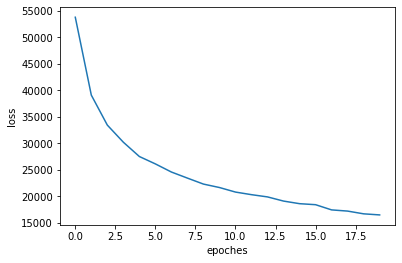

In [7]:
import matplotlib.pyplot as plt

plt.plot(range(nn.epochs), nn.eval_['cost'])
plt.xlabel('epoches')
plt.ylabel('loss')
plt.show()

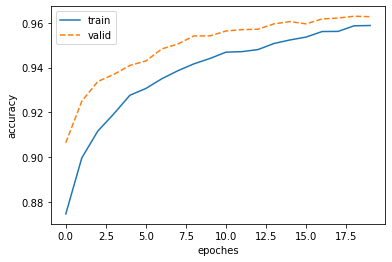

In [8]:
plt.plot(range(nn.epochs), nn.eval_['train_acc'],
         label='train')
plt.plot(range(nn.epochs), nn.eval_['valid_acc'],
         label='valid', linestyle='--')
plt.xlabel('epoches')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.show()

In [9]:
y_test_pred = nn.predict(X_test)
acc = (np.sum(y_test == y_test_pred) / X_test.shape[0]) * 100
print('acc test: ', acc)

acc test:  95.5


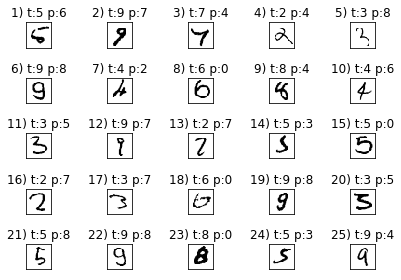

In [10]:
miscl_img = X_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
misc_lab = y_test_pred[y_test != y_test_pred][:25]

fig, ax = plt.subplots(nrows=5,
                       ncols=5,
                       sharex=True,
                       sharey=True)
ax = ax.flatten()
for i in range(25):
    img = miscl_img[i].reshape(28, 28)
    ax[i].imshow(img,
                 cmap='Greys',
                 interpolation='nearest')
    ax[i].set_title(f'{i+1}) t:{correct_lab[i]} p:{misc_lab[i]}')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [ ]:
500